In [1]:
import sys
sys.path.append('../../..')
import cortexetl as c_etl

ma_sm = c_etl.analysis_initial_processing("2_whisker_deflections_soma_0__19_11_24.yaml", loglevel="ERROR")
print("ma_sm loaded")
ma_orig = c_etl.analysis_initial_processing("2_whisker_deflections_soma_0__original_wiring_5_12_24.yaml", loglevel="ERROR")
print("ma_orig loaded")

ma_sm loaded
ma_orig loaded


In [2]:
report_df_orig = ma_orig.hex0_soma.repo.report.df
report_df_orig['time'] = (report_df_orig['time'] * 10.0).astype('int')
soma_means_df_orig = report_df_orig.reset_index().groupby(['simulation_id', 'window', 'neuron_class', 'time'], observed=True)['value'].mean().reset_index()
soma_means_df_orig['time'] = soma_means_df_orig['time'].astype('float') / 10.0
# print(report_df_orig)


report_df_sm = ma_sm.hex0_soma.repo.report.df
report_df_sm['time'] = (report_df_sm['time'] * 10.0).astype('int')
soma_means_df_sm = ma_sm.hex0_soma.repo.report.df.reset_index().groupby(['simulation_id', 'window', 'neuron_class', 'time'], observed=True)['value'].mean().reset_index()
soma_means_df_sm['time'] = soma_means_df_sm['time'].astype('float') / 10.0
# print(report_df_sm)

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

conn_spont_soma_means_df_orig = soma_means_df_orig.etl.q(window="conn_spont").reset_index()
evoked_mean_soma_means_df_orig = soma_means_df_orig.etl.q(window="evoked_SOZ_100ms").reset_index()

conn_spont_soma_means_df_sm = soma_means_df_sm.etl.q(window="conn_spont").reset_index()
evoked_mean_soma_means_df_sm = soma_means_df_sm.etl.q(window="evoked_SOZ_100ms").reset_index()

ncs = evoked_mean_soma_means_df_orig.neuron_class.unique()

n_ncs = len(ncs)
nrows = n_ncs
ncols = 2

_, axes = plt.subplots(nrows, ncols, figsize=(8, nrows*1.5))

for row_i, nc in enumerate(ncs):
    
    nc_conn_spont_soma_means_df_orig = conn_spont_soma_means_df_orig.etl.q(neuron_class=nc)
    nc_evoked_mean_soma_means_df_orig = evoked_mean_soma_means_df_orig.etl.q(neuron_class=nc)
    
    nc_conn_spont_soma_means_df_sm = conn_spont_soma_means_df_sm.etl.q(neuron_class=nc)
    nc_evoked_mean_soma_means_df_sm = evoked_mean_soma_means_df_sm.etl.q(neuron_class=nc)

    axes[row_i][0].plot(nc_conn_spont_soma_means_df_orig.time, nc_conn_spont_soma_means_df_orig.value, lw=0.4)
    axes[row_i][0].plot(nc_conn_spont_soma_means_df_sm.time, nc_conn_spont_soma_means_df_sm.value, lw=0.4)
    axes[row_i][0].set_ylabel(nc)
    
    
    sigma = 0.001  # Standard deviation for the Gaussian kernel
#     smoothed_trace = gaussian_filter1d(trace, sigma=sigma)
    
    axes[row_i][1].plot(nc_evoked_mean_soma_means_df_orig.time, gaussian_filter1d(nc_evoked_mean_soma_means_df_orig.value, sigma=sigma), lw=0.4)
    axes[row_i][1].plot(nc_evoked_mean_soma_means_df_sm.time, gaussian_filter1d(nc_evoked_mean_soma_means_df_sm.value, sigma=sigma), lw=0.4)





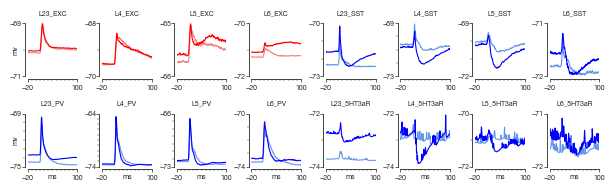

In [49]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.ticker as ticker
# import seaborn as sns
# sns.set()

conn_spont_soma_means_df_orig = soma_means_df_orig.etl.q(window="conn_spont").reset_index()
evoked_mean_soma_means_df_orig = soma_means_df_orig.etl.q(window="evoked_SOZ_100ms").reset_index()

conn_spont_soma_means_df_sm = soma_means_df_sm.etl.q(window="conn_spont").reset_index()
evoked_mean_soma_means_df_sm = soma_means_df_sm.etl.q(window="evoked_SOZ_100ms").reset_index()

# ncs = evoked_mean_soma_means_df_orig.neuron_class.unique()

# n_ncs = len(ncs)
# nrows = 2
# ncols = int(n_ncs / 2)

nc_groupings = [[['L23_EXC', 'L4_EXC', 'L5_EXC', 'L6_EXC'], ['L23_SST', 'L4_SST', 'L5_SST', 'L6_SST']],
                 [['L23_PV', 'L4_PV', 'L5_PV', 'L6_PV'], ['L23_5HT3aR', 'L4_5HT3aR', 'L5_5HT3aR', 'L6_5HT3aR']]]
  
n_rows = len(nc_groupings)
n_groups_per_row = len(nc_groupings[0])
n_ncs_per_group = len(nc_groupings[0][0])
n_cols = n_groups_per_row * n_ncs_per_group

_, axes = plt.subplots(n_rows, n_cols, figsize=(0.78*n_cols, 1.0*n_rows))

for row_i, row_nc_groupings in enumerate(nc_groupings): 
    for nc_grouping_row_ind, nc_grouping in enumerate(row_nc_groupings):
        for nc_i, nc in enumerate(nc_grouping):
            col_i = nc_grouping_row_ind * n_ncs_per_group + nc_i
            ax = axes[row_i][col_i]
            
            orig_ls = '-'
            sm_ls = '-'
            
            orig_c='cornflowerblue'
            sm_c = 'blue'
            if "EXC" in nc: 
                
                orig_c='lightcoral'
                sm_c='red'
            
            nc_evoked_mean_soma_means_df_orig = evoked_mean_soma_means_df_orig.etl.q(neuron_class=nc)
            nc_evoked_mean_soma_means_df_sm = evoked_mean_soma_means_df_sm.etl.q(neuron_class=nc)

            ax.set_title(nc, fontsize=5)
            
#             sigma = 0.001
            sigma = 2.0
            lw = 0.8

            # Calculate the smoothed data
            orig_values = gaussian_filter1d(nc_evoked_mean_soma_means_df_orig.value, sigma=sigma)
            sm_values = gaussian_filter1d(nc_evoked_mean_soma_means_df_sm.value, sigma=sigma)

            # Plot the smoothed data
            ax.plot(nc_evoked_mean_soma_means_df_orig.time, orig_values, lw=lw, label='Orig', c=orig_c, ls=orig_ls)
            ax.plot(nc_evoked_mean_soma_means_df_sm.time, sm_values, lw=lw, label='SM', c=sm_c, ls=sm_ls)

            # Calculate min and max for the y-axis
            y_min = np.floor(min(orig_values.min(), sm_values.min()))
            y_max = np.ceil(max(orig_values.max(), sm_values.max()))
            
            # Set y-limits to the floor of the min and the ceil of the max
            ax.set_ylim(y_min, y_max)
            
            # Set major locator to only show min and max y-axis values
            ax.yaxis.set_major_locator(ticker.FixedLocator([y_min, y_max]))
            
            # Set minor ticks to be every 1 unit
            ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
            
            if col_i == 0: ax.set_ylabel('mv', fontsize=5, labelpad=-6)
            if row_i == 1: ax.set_xlabel('ms', fontsize=5, labelpad=-5)
                
            ax.tick_params(axis='x', which='both', pad=2, labelsize=5)
            ax.tick_params(axis='y', which='both', pad=0, labelsize=5)
                
            ax.xaxis.set_major_locator(ticker.FixedLocator([-20,100]))
            ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
            
            ax.set_xlim([-20, 100])
            
            ax.spines['left'].set_position(('outward', 2))
            ax.spines['bottom'].set_position(('outward', 2))
            
# axes[0][0].legend()
# axes[1][0].legend()


plt.tight_layout()
plt.subplots_adjust(wspace=.5, hspace=0.7) #, hspace=.3
plt.savefig('evoked_membrane_potentials.pdf')
plt.show()
plt.close()
    

In [ ]:
import pandas as pd

# Sparsity
a_hex0.features.by_gid_and_trial.df['did_spike'] = a_hex0.features.by_gid_and_trial.df['count'].astype(bool)
means_by_neuron_class = a_hex0.features.by_gid_and_trial.df.groupby(['simulation_id', 'window', 'neuron_class']).mean().reset_index()

neuron_classes, vivo_df, rp_psth_df, svo_psth_df = c_etl.evoked_processing(a_hex0)

silico_bin_size=0.5; silico_sigma=2
nc_stat_and_mask_df = a_hex0.custom['sim_mask'] #.etl.q(bin_size=silico_bin_size, sigma=silico_sigma)

means_by_neuron_class = pd.merge(means_by_neuron_class, nc_stat_and_mask_df.drop(['window'], axis=1), on=['simulation_id']) # , 'neuron_class'
means_by_neuron_class = means_by_neuron_class.etl.q(vpm_l5e_cond_scaling_factor=1.36, window='evoked_SOZ_100ms')

In [ ]:
# c_etl.evoked_ratios_line_plot(a_hex0, neuron_classes)
# c_etl.evoked_heatmaps(a_hex0)
# c_etl.compare_time_courses(a_hex0, vivo_df, silico_bin_size=0.5, silico_sigma=2)
c_etl.psth_plots(a_hex0, neuron_classes, rp_psth_df, svo_psth_df)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import blueetl as etl
from scipy.interpolate import interp1d
import seaborn as sns
from matplotlib import cm
import sys
import matplotlib.patches as mpatches
from scipy.ndimage import gaussian_filter
import os
import cortexetl as c_etl
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap

def layer_and_pairwise_sparsity_comparison(nc_stat_and_mask_df, decay, nc_pairs, path, xlim, xticks, figsize=(1.64, 1.64), xlabel="Time (ms)"):

    flattened_ncs = [item for sublist in nc_pairs for item in sublist]

    plt.figure(figsize=figsize)
    for simulation_id in nc_stat_and_mask_df.simulation_id.unique():
        for nc_pair in nc_pairs:
            cs = [c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES[nc_pair[0]]['color'], c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES[nc_pair[1]]['color']]
            q_df = nc_stat_and_mask_df.etl.q(simulation_id=simulation_id, neuron_class=nc_pair, SimBad100p50p25pDecayOverlySustained=False)
#             q_df = nc_stat_and_mask_df.etl.q(simulation_id=simulation_id, neuron_class=nc_pair)
            if len(q_df):
                x_to_plot =[q_df.etl.q(neuron_class=nc_pair[0]).iloc[0][decay], q_df.etl.q(neuron_class=nc_pair[1]).iloc[0][decay]]
                y_to_plot = [flattened_ncs.index(nc_pair[0]) + 1, flattened_ncs.index(nc_pair[1]) + 1]
                plt.plot(x_to_plot, y_to_plot, c='grey', lw=.2)
                plt.scatter(x_to_plot, y_to_plot, c=cs, s=0.2)

#     for nc_pair in nc_pairs:
#         cs = [c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES[nc_pair[0]]['color'], c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES[nc_pair[1]]['color']]
#         nc_pair_df = vivo_df.etl.q(neuron_class=nc_pair, bin_size=1.0, sigma=1, experiment=vivo_exp)
#         if (len(nc_pair_df)):
#             x_to_plot = [nc_pair_df.etl.q(neuron_class=nc_pair[0]).iloc[0][decay], nc_pair_df.etl.q(neuron_class=nc_pair[1]).iloc[0][decay]]
#             y_to_plot = [flattened_ncs.index(nc_pair[0]) + 1, flattened_ncs.index(nc_pair[1]) + 1]
#             plt.plot(x_to_plot, y_to_plot, c='k', lw=1.0)
#             plt.scatter(x_to_plot, y_to_plot, c=cs, s=1.3)

    plt.gca().set_xlabel(xlabel)
    plt.gca().set_xlim(xlim)
    plt.gca().set_xticks(ticks=xticks)
    plt.gca().set_yticks(ticks=np.arange(len(flattened_ncs)) + 1,labels=[c_etl.neuron_class_label_map[nc] for nc in flattened_ncs])
    plt.tight_layout()
    plt.savefig(path)
    plt.close()
    
layer_and_pairwise_sparsity_comparison(means_by_neuron_class, 'did_spike', [["L6_INH", "L6_EXC"], ["L5_INH", "L5_EXC"], ["L4_INH", "L4_EXC"], ["L23_INH", "L23_EXC"]], str(a_hex0.figpaths.root) + '/' + "sparsity.pdf", [0.0, 0.4], [0.0, 0.1, 0.2, 0.3, 0.4], figsize=(2, 3), xlabel='Proportion of\nspiking cells')


In [ ]:
hm_dims = (a_hex0.analysis_config.custom['heatmap_dims']['hor_key'], 
           a_hex0.analysis_config.custom['heatmap_dims']['ver_key'], 
           a_hex0.analysis_config.custom['heatmap_dims']['x_key'], 
           a_hex0.analysis_config.custom['heatmap_dims']['y_key'])


# means_by_neuron_class.etl.q(neuron_class='ALL')

c_etl.heatmap(means_by_neuron_class.etl.q(neuron_class='ALL'), 
              "did_spike", 
              str(a_hex0.figpaths.root) + '/' + "sparsity_heatmap", 
              *hm_dims, 
              mask_key="SimBad100p50p25pDecayOverlySustained", 
              figsize=(6, 4.5),
             override_cmap='cividis')

In [ ]:
filtered_df = a_hex0.features.by_gid_and_trial.df.etl.q(neuron_class='ALL', window='evoked_SOZ_100ms')


# print(a_hex0.features.by_gid_and_trial.df.etl.q(neuron_class='ALL', window='evoked_SOZ_100ms')['count'] )

In [ ]:
filtered_df['didnt_spike'] = filtered_df['count'] == 0
filtered_df['spiked_only_once'] = filtered_df['count'] == 1
filtered_df['spiked_more_than_once'] = filtered_df['count'] > 1
filtered_df['spiked_atleast_once'] = filtered_df['count'] >= 1
counts_filtered_df = filtered_df.groupby(['simulation_id']).sum()
counts_filtered_df['proportion_spiking_only_once'] = counts_filtered_df['spiked_only_once'] / counts_filtered_df['spiked_atleast_once']

counts_filtered_df = pd.merge(counts_filtered_df, nc_stat_and_mask_df.drop(['window'], axis=1), on=['simulation_id'])

In [ ]:
c_etl.heatmap(counts_filtered_df, 
              "proportion_spiking_only_once", 
              str(a_hex0.figpaths.root) + '/' + "proportion_spiking_only_once_heatmap", 
              *hm_dims, 
              mask_key="SimBad100p50p25pDecayOverlySustained", 
              figsize=(6, 4.5),
             override_cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True, reverse=True))

# Fig 5B

In [ ]:
a_hex0.analysis_config.custom['plot_rasters'] = True
a_hex0.analysis_config.custom['raster_windows'][1]['half_stim_period'] = [2.5, 2.5]

c_etl.plot_rasters(a_hex0, custom_file_path=str(a_hex0.figpaths.root) + '/', simulation_filter={"ca":1.05, "depol_stdev_mean_ratio": 0.4, "desired_connected_proportion_of_invivo_frs": 0.3, "vpm_pct":10.0, "vpm_l5e_cond_scaling_factor":1.36})
# c_etl.plot_rasters(a_hex0, custom_file_path='figures/Fig7A-Sim2', simulation_filter={"ca":1.1, "depol_stdev_mean_ratio": 0.2, "desired_connected_proportion_of_invivo_frs": 0.9})

# Raster video

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import time
import os
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from functools import partial

from blueetl.constants import *
from blueetl.parallel import call_by_simulation

import cortexetl as c_etl

def plot_simulation_raster(simulation_row, filtered_dataframes, analysis_config, raster_option_combination):
        
    plot_raster(simulation_row, 
                        filtered_dataframes['windows'].iloc[0], 
                        filtered_dataframes['spikes'], 
                        filtered_dataframes['neurons'], 
                        filtered_dataframes['neuron_classes'], 
                        raster_option_combination,
                        analysis_config,
                        simulation_histograms=filtered_dataframes['histograms'])


def plot_rasters(a, custom_file_path=None, simulation_filter={}):

    a.repo.simulations.df["SummaryPNG"] = a.repo.simulations.df['rasters_dir'] / (a.repo.simulations.df['simulation_string'].astype(str) + "_SUMMARY.png")

    for dict_to_unpack in a.analysis_config.custom['raster_windows']:

        window_str = list(dict_to_unpack.keys())[0]
        fig_dims = list(dict_to_unpack.values())[0]

        if (type(fig_dims) == list):
            fig_width = fig_dims[0]
            fig_height = fig_dims[1]
        else:
            fig_width = fig_dims
            fig_height = fig_width * 0.6
        
        raster_option_combinations = [
                                    RasterOptions(a, window_str=window_str, neuron_group_y_axis_equal=False, use_spikes=True, smoothing_type='Gaussian', hist_bin_size=3.0, kernel_sd=1.0, neuron_classes=c_etl.LAYER_EI_NEURON_CLASSES, neuron_class_groupings=c_etl.NEURON_CLASS_NO_GROUPINGS, fig_width=fig_width, fig_height=fig_height, custom_file_path=custom_file_path),
                                    RasterOptions(a, window_str=window_str, neuron_group_y_axis_equal=True, use_spikes=False, smoothing_type='Gaussian', hist_bin_size=3.0, kernel_sd=1.0, neuron_classes=['ALL'], neuron_class_groupings=[['ALL']], extra_string='All', fig_width=fig_width, fig_height=fig_height, custom_file_path=custom_file_path),
                                    RasterOptions(a, window_str=window_str, neuron_group_y_axis_equal=True, use_spikes=False, smoothing_type='Gaussian', hist_bin_size=3.0, kernel_sd=1.0, neuron_classes=c_etl.LAYER_EI_NEURON_CLASSES + ['ALL_EXC', 'ALL_INH'], neuron_class_groupings=c_etl.LAYER_EI_NEURON_CLASS_GROUPINGS, extra_string='LayerEI', fig_width=fig_width, fig_height=fig_height, custom_file_path=custom_file_path),
                                    RasterOptions(a, window_str=window_str, neuron_group_y_axis_equal=True, use_spikes=False, smoothing_type='Gaussian', hist_bin_size=5.0, kernel_sd=1.0, neuron_classes=c_etl.LAYER_EI_NEURON_CLASSES + ['ALL_EXC', 'ALL_INH'], neuron_class_groupings=c_etl.LAYER_EI_NEURON_CLASS_GROUPINGS, extra_string='LayerEI', fig_width=fig_width, fig_height=fig_height, custom_file_path=custom_file_path, lw=0.4, seperator_lw=0.2)
                                    ]

        if (a.analysis_config.custom['plot_rasters']):

            print(f"\n----- Plot rasters, window: {window_str} -----")

            for roc in raster_option_combinations:

                dataframes={
                        "spikes": a.repo.report.df.etl.q(neuron_class=roc.neuron_classes, window=roc.window_str, trial=0),
                        "windows": a.repo.windows.df.etl.q(window=roc.window_str), 
                        "neurons": a.repo.neurons.df,
                        "neuron_classes": a.repo.neuron_classes.df.etl.q(neuron_class=roc.neuron_classes),
                        "histograms": a.features.histograms.df.etl.q(neuron_class=roc.neuron_classes, window=roc.window_str, bin_size=roc.hist_bin_size, smoothing_type=roc.smoothing_type, kernel_sd=roc.kernel_sd)
                        }
            
                results = call_by_simulation(a.repo.simulations.df.etl.q(simulation_filter), 
                                                dataframes, 
                                                func=partial(plot_simulation_raster, analysis_config=a.analysis_config.custom, raster_option_combination=roc), how="series")

        if (a.analysis_config.custom['create_raster_videos']):

            print(f"\n----- Create raster videos, window: {window_str} -----")

            for roc in raster_option_combinations:
                if (a.repo.windows.df.etl.q(window=window_str).iloc[0]['window_type'] == "spontaneous"):
                    for mask_key in ['', 'bursting', 'bursting_or_fr_above_threshold_or_ei_corr_r_out_of_range']:
                        roc.create_video(a, mask_key=mask_key)

                elif (a.repo.windows.df.etl.q(window=window_str).iloc[0]['window_type'] == "evoked_stimulus_onset_zeroed"):
                    for mask_key_and_invert_mask_bool in [['', False], ['overly_sustained_response', False], ['overly_sustained_response', True], ['higher_secondary_peak', False], ['higher_secondary_peak', True], ['too_much_trial_to_trial_variance', False], ['too_much_trial_to_trial_variance', True], ['evoked_mask', False], ['evoked_mask', True]]:
                        roc.create_video(a, mask_key=mask_key_and_invert_mask_bool[0], invert_mask=mask_key_and_invert_mask_bool[1])




class RasterOptions(object):

    def __init__(self, a, window_str='', neuron_group_y_axis_equal=True, use_spikes=True, smoothing_type='', hist_bin_size=3.0, kernel_sd=1.0, neuron_classes=[], neuron_class_groupings=[], extra_string='', fig_width=20, fig_height=15, custom_file_path=None, lw=0.2, seperator_lw=0.2):

        self.window_str = window_str
        self.neuron_group_y_axis_equal = neuron_group_y_axis_equal
        self.use_spikes = use_spikes
        self.smoothing_type = smoothing_type
        self.hist_bin_size = hist_bin_size
        self.kernel_sd = kernel_sd
        self.neuron_classes = neuron_classes
        self.neuron_class_groupings = neuron_class_groupings
        self.extra_string = extra_string
        self.fig_width = fig_width
        self.fig_height = fig_height
        self.lw = lw
        self.seperator_lw = seperator_lw

        
        windows = pd.merge(a.repo.simulations.df.reset_index().drop(["index"], axis=1), a.repo.windows.df.reset_index()).set_index(['index'])
        if (custom_file_path == None):
            custom_file_path = windows['rasters_dir'].astype(str)

        self.options_str = "{spikes}".format(spikes="S_" if use_spikes == True else "NS_") + smoothing_type + "_" + str(hist_bin_size) + "_" + str(kernel_sd) + "_" + "{yax}".format(yax="YNE_" if neuron_group_y_axis_equal == True else "YE_") + extra_string
        self.df_file_path_key = self.options_str + '_rasters_path_png'
        self.df_file_path_pdf_key = self.options_str + '_rasters_path_pdf'

        a.repo.windows.df.loc[windows.index, self.df_file_path_key] = custom_file_path + (windows['window'].astype(str) + "_" + self.options_str + "_RASTER.png")
        a.repo.windows.df.loc[windows.index, self.df_file_path_pdf_key] = custom_file_path+ (windows['window'].astype(str) + "_" + self.options_str + "_RASTER.pdf")


    def create_video(self, a, mask_key='', invert_mask=False):

        windows_df = a.repo.windows.df.etl.q(window=self.window_str)
        
        if (mask_key != ''):
            windows_with_stats_df = pd.merge(windows_df, a.custom['custom_simulations_post_analysis'])
            q = {mask_key: invert_mask}
            windows_df = windows_with_stats_df.etl.q(q)

        raster_videos_window_dir = str(a.figpaths.raster_videos) + "/" + self.window_str + "/" + mask_key + str(invert_mask) + "/"
        os.makedirs(raster_videos_window_dir, exist_ok=True)

        video_fn = raster_videos_window_dir + self.window_str + "_" + self.options_str + '_' + mask_key + ":" + str(invert_mask) + ".mp4"

        c_etl.video_from_image_files(windows_df[self.df_file_path_key].astype(str).tolist(), video_fn)


def renormalise_psth(psth):
    new_hist = psth  - np.min(psth)
    new_hist = new_hist / np.max(new_hist)
    return new_hist

def plot_raster(simulation_row, window_row, window_spikes, circuit_neurons, neuron_classes, raster_option_combination, analysis_config, simulation_histograms=None, spont_ei_corr_rval=-5.0):

    sns.set(style="ticks", context="paper", font="Helvetica Neue",
        rc={"axes.labelsize": 7, "legend.fontsize": 6, "axes.linewidth": 0.6, "xtick.labelsize": 6, "ytick.labelsize": 6,
            "xtick.major.size": 2, "xtick.major.width": 0.5, "xtick.minor.size": 1.5, "xtick.minor.width": 0.3,
            "ytick.major.size": 2, "ytick.major.width": 0.5, "ytick.minor.size": 1.5, "ytick.minor.width": 0.3,
            "axes.titlesize": 7, "axes.spines.right": False, "axes.spines.top": False})

    start_time = time.time()
    plt.figure(figsize=(raster_option_combination.fig_width, raster_option_combination.fig_height))
    ax = plt.gca()

    # SET NEURON CLASS COLOURS
    neuron_classes = neuron_classes.copy()
    neuron_classes.loc[:, 'c'] = neuron_classes.apply(lambda row : c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES[row['neuron_class']]["color"], axis=1)

    # SET NEURON CLASS START 
    if (not raster_option_combination.neuron_group_y_axis_equal):
        neuron_classes['cum_sum'] = neuron_classes[COUNT].cumsum()
        neuron_classes['start_pos'] = neuron_classes['cum_sum'].shift().fillna(0)
    else:
        neuron_classes['start_pos'] = 0
        neuron_classes['cum_sum'] = 0
        for neuron_class_index, neuron_class in neuron_classes.iterrows():            
            for neuron_class_grouping_index, neuron_class_grouping in enumerate(raster_option_combination.neuron_class_groupings):
                if neuron_class["neuron_class"] in neuron_class_grouping:
                    neuron_classes.loc[neuron_class_index, 'start_pos'] = neuron_class_grouping_index * 5000
                    neuron_classes.loc[neuron_class_index, 'cum_sum'] = neuron_class_grouping_index * 5000 + 5000


    # PLOT SPIKES
    if (raster_option_combination.use_spikes):
        window_spikes = pd.merge(neuron_classes, window_spikes)
        window_spikes = window_spikes.set_index([CIRCUIT_ID, NEURON_CLASS, GID])
        circuit_neurons = circuit_neurons.set_index([CIRCUIT_ID, NEURON_CLASS, GID])
        window_spikes = circuit_neurons.join(window_spikes, how='inner')

        shuffled_within_neuron_class = True
        if (shuffled_within_neuron_class):
            for neuron_class_index, neuron_class in neuron_classes.iterrows(): 
                nc_w_spikes = window_spikes.etl.q(neuron_class=neuron_class[NEURON_CLASS])
                nc_random_map = np.arange(neuron_class[COUNT])
                np.random.shuffle(nc_random_map)
                shuffled_neuron_class_indices = nc_w_spikes.neuron_class_index.map(lambda x: nc_random_map[x])
                neuron_scatter_pos = nc_w_spikes['start_pos'] + shuffled_neuron_class_indices
                ax.scatter(nc_w_spikes[TIME], neuron_scatter_pos, s=0.1, c=nc_w_spikes['c'], linewidths=0) #, facecolors='c', s=0.2

        else:
            neuron_scatter_pos = window_spikes['start_pos'] + window_spikes['neuron_class_index']
            ax.scatter(window_spikes[TIME], neuron_scatter_pos, s=0.1, c=window_spikes['c'], linewidths=0)



    # OPTIONALLY LOAD INVIVO_HISTOGRAMS
    if (window_row['window_type'] in ['evoked_stimulus_onset_zeroed', 'evoked_cortical_onset_zeroed']):
        vivo_df = pd.read_feather(analysis_config['vivo_df']).reset_index()
        vivo_neuron_classes = vivo_df["neuron_class"].unique()

    # PLOT DIVIDERS AND HISTOGRAMS
    for neuron_class_index, neuron_class in neuron_classes.iterrows():
        plt.plot([window_row['t_start'], window_row['t_stop']], [neuron_class['start_pos'], neuron_class['start_pos']], lw=raster_option_combination.seperator_lw, c='k')

        if (simulation_histograms is not None):

            bin_indices, hist_array = c_etl.hist_elements(simulation_histograms.etl.q(simulation_id=window_row[SIMULATION_ID], 
                                                                                        neuron_class=neuron_class[NEURON_CLASS], 
                                                                                        window=raster_option_combination.window_str, 
                                                                                        bin_size=raster_option_combination.hist_bin_size, 
                                                                                        smoothing_type=raster_option_combination.smoothing_type, 
                                                                                        kernel_sd=raster_option_combination.kernel_sd))


            if (hist_array.shape[0] != 0):
                hist_max = np.max(hist_array)
                if (hist_max != 0.0):
                    max_normalised_hist = hist_array / np.max(hist_array)

                    if (not raster_option_combination.neuron_group_y_axis_equal):
                        plt.plot(window_row['t_start'] + (bin_indices * raster_option_combination.hist_bin_size), neuron_class['cum_sum'] - neuron_class[COUNT]*max_normalised_hist, c=neuron_class['c'], lw=raster_option_combination.lw)
                    else:
                        plt.plot(window_row['t_start'] + (bin_indices * raster_option_combination.hist_bin_size), neuron_class['cum_sum'] - 5000*(max_normalised_hist), c=neuron_class['c'], lw=raster_option_combination.lw)

                    if (window_row['window_type'] in ['evoked_stimulus_onset_zeroed', 'evoked_cortical_onset_zeroed']):
                        if (neuron_class[NEURON_CLASS] in list(c_etl.vivo_neuron_class_map.keys())):
                            in_vivo_neuron_class = c_etl.vivo_neuron_class_map[neuron_class[NEURON_CLASS]]
                            if in_vivo_neuron_class in vivo_neuron_classes:
                                nc_data = vivo_df[(vivo_df["neuron_class"] == in_vivo_neuron_class) & (vivo_df["barrel"] == "C2")].iloc[0]
                                nc_mean = nc_data["psth_mean"]
                                # nc_sd = nc_data["psth_sd"]

                                x = window_row['t_start'] - 50.0 + (1.0 * np.asarray(range(len(nc_mean))))

                                if (not raster_option_combination.neuron_group_y_axis_equal):
                                    y = neuron_class['cum_sum'] - neuron_class[COUNT]*nc_mean
                                else:
                                    y = neuron_class['cum_sum'] - 5000*(nc_mean)


                                plt.plot(x, y, c=neuron_class['c'], lw=raster_option_combination.lw, linestyle='--')




    # PLOT OPTIONS AND SAVE
    x_tick_distance = 5
    duration = window_row['t_stop'] - window_row['t_start']
    if (duration > 50):
        x_tick_distance = 10
    if (duration > 100):
        x_tick_distance = 100
    if (duration > 1000):
        x_tick_distance = 1000

    ax.set_yticks(neuron_classes['start_pos'] + (neuron_classes[COUNT]/2.0), minor=False)
    if (raster_option_combination.use_spikes):
        ax.set_yticklabels([c_etl.neuron_class_label_map[nc] for nc in neuron_classes['neuron_class']], minor=False)
    else:
        ax.set_yticks(neuron_classes['start_pos'] + (5000.0/2.0), minor=False)
#         print([nc_str.split('_')[0] for nc_str in neuron_classes['neuron_class']])
        ax.set_yticklabels([nc_str.split('_')[0] for nc_str in neuron_classes['neuron_class']], minor=False)

    ax.set_xlim([window_row['t_start'], window_row['t_stop']])
    ax.set_ylim([0, neuron_classes['cum_sum'].max()])
    ax.set_ylabel('')
    # ax.set_xlabel('Time from window start (ms)')
    ax.set_xlabel('Time (ms)')
    ax.set_axisbelow(True)
    title_str = str(simulation_row['simulation_id']) + " " + simulation_row['simulation_string'] #+ "    " + raster_option_combination.options_str
    if (spont_ei_corr_rval != -5.0):
        title_str += "  spont_ei_corr_rval: " + str(np.around(spont_ei_corr_rval, decimals=3))
    ax.set_title(title_str)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_distance))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_distance))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.invert_yaxis()

    plt.savefig(window_row[raster_option_combination.df_file_path_key], bbox_inches='tight', dpi=600)
    plt.savefig(window_row[raster_option_combination.df_file_path_pdf_key], bbox_inches='tight')
    plt.close()

    print("Raster generated: ", "{:.2f}".format(time.time() - start_time), 's')

plot_rasters(a_hex0)




# Fig 7B

In [ ]:
a = a_hexO1

import numpy
import pandas
import os
import tqdm
import cortexetl as c_etl
from blueetl.parallel import call_by_simulation
import pandas as pd
from functools import partial
from matplotlib import pyplot as plt



def make_t_bins(t_start, t_end, t_step):
    t_bins = numpy.arange(t_start, t_end + t_step, t_step)
    return t_bins

def flatten_locations(locations, flatmap):
    if isinstance(flatmap, list):
        flat_locations = locations[flatmap].values
    else:
        from voxcell import VoxelData
        fm = VoxelData.load_nrrd(flatmap)
        flat_locations = fm.lookup(locations.values).astype(float)
        flat_locations[flat_locations == -1] = numpy.NaN
    return pandas.DataFrame(flat_locations, index=locations.index)


def make_spatial_bins(flat_locations, nbins=1000):
    mn = numpy.nanmin(flat_locations, axis=0)
    mx = numpy.nanmax(flat_locations, axis=0)
    ratio = (mx[1] - mn[1]) / (mx[0] - mn[0]) # ratio * nx ** 2 = nbins
    nx = int(numpy.sqrt(nbins / ratio))
    ny = int(nbins / nx)
    binsx = numpy.linspace(mn[0], mx[0] + 1E-3, nx + 1)
    binsy = numpy.linspace(mn[1], mx[1] + 1E-3, ny + 1)
    return binsx, binsy

def make_histogram_function(t_bins, loc_bins, location_dframe, spikes):
    t_step = numpy.mean(numpy.diff(t_bins))
    fac = 1000.0 / t_step
    nrns_per_bin = numpy.histogram2d(location_dframe.values[:, 0],
                                     location_dframe.values[:, 1],
                                     bins=loc_bins)[0]
    nrns_per_bin = nrns_per_bin.reshape((1,) + nrns_per_bin.shape)

    spikes = spikes.loc[numpy.in1d(spikes.values, location_dframe.index.values)]
    t = spikes.index.values
    loc = location_dframe.loc[spikes['gid']].values
    raw, _ = numpy.histogramdd((t, loc[:, 0], loc[:, 1]), bins=(t_bins,) + loc_bins)
    raw = fac * raw / (nrns_per_bin + 1E-6)
    return raw

def save(hist, t_bins, loc_bins, out_root):
    if not os.path.isdir(out_root):
        _ = os.makedirs(out_root)
    import h5py
    h5 = h5py.File(os.path.join(out_root, "spiking_activity_3d.h5"), "w")
    grp_bins = h5.create_group("bins")
    grp_bins.create_dataset("t", data=t_bins)
    grp_bins.create_dataset("x", data=loc_bins[0])
    grp_bins.create_dataset("y", data=loc_bins[1])

    grp_data = h5.create_group("histograms")
    for i, val in enumerate(hist.get()):
        grp_data.create_dataset("instance{0}".format(i), data=val)
    mn_data = numpy.mean(numpy.stack(hist.get(), -1), axis=-1)
    grp_data.create_dataset("mean", data=mn_data)
    return mn_data

def setup_cmap(hist, plotting_options, hist_mean=[]):
    
    hist_for_mask = hist
    if (len(hist_mean)):
        hist_for_mask = hist_mean
    
    masked_hist = hist
    mx_clim = numpy.percentile(hist, plotting_options['max_lim_pct'])
    mn_clim = numpy.percentile(hist, plotting_options['min_lim_pct'])
    indices_to_mask = numpy.asarray(numpy.argwhere(hist_for_mask <= plotting_options['mask_fr']))
    for pair in indices_to_mask:
        if (len(hist_mean)):
            masked_hist[:, pair[0], pair[1]] = numpy.nan
        else:
            masked_hist[pair[0], pair[1]] = numpy.nan
    
    
    cmap = plotting_options['cmap']
    cmap.set_bad('white',1.)
    
    clim = [mn_clim, mx_clim]
    
    return cmap, clim, masked_hist
    

def plot_and_save_single_image(hist, plotting_options, path):

    cmap, clim, masked_hist = setup_cmap(hist, plotting_options)
    
    fig = plt.figure()
    ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])
    img = ax.imshow(masked_hist, cmap=cmap, clim=clim)
    plt.colorbar(img, cmap=cmap, label='FR (spikes / s')
    plt.box(False)
    plt.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
    plt.savefig(path)
    plt.close()


import os
import numpy
import tqdm
import matplotlib
from matplotlib import pyplot as plt

#     plot(hist, t_bins, loc_bins, images_dir, flatspace_video_opt['delete_images'], flatspace_path_pre, plotting_options, hist_mean=hist_mean)
def plot(hist, t_bins, loc_bins, images_dir, delete_images, video_output_root, plotting_options, min_color_lim_pct=-1, hist_mean=[]):
    
    if not os.path.isdir(images_dir):
        _ = os.makedirs(images_dir)
    
    cmap, clim, masked_hist = setup_cmap(hist, plotting_options, hist_mean=hist_mean)
    
    fps = []
    for t_start, t_end, bin_index in tqdm.tqdm(zip(t_bins[:-1], t_bins[1:], list(range(len(t_bins))))):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])
        img = ax.imshow(masked_hist[bin_index, :, :], cmap=cmap, clim=clim)
        plt.colorbar(img, cmap=cmap, label='FR (spikes / s')
        
        ax.set_title("{0} - {1} ms".format(t_start, t_end))
        plt.box(False)
        plt.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
        fn = "frame{:04d}.png".format(bin_index)
        fp = os.path.join(images_dir, fn)
        fig.savefig(fp)
        fps.append(fp)
        if (bin_index == 0):
            fn = "frame{:04d}.pdf".format(bin_index)
            fp = os.path.join(images_dir, fn)
            fig.savefig(fp)
        
        plt.close(fig)
    
    print(video_output_root)
    c_etl.video_from_image_files(fps, video_output_root + ".mp4")
    if delete_images:
        for f in fps:
            os.remove(f)

import numpy
from scipy.ndimage import gaussian_filter
def single_flatspace_video(simulation_row, 
                           filtered_dataframes, 
                           flat_locations, 
                           flatspace_video_opt, 
                           analysis_config,
                           plotting_options,
                           flatspace_path_pre=None, 
                           images_dir=None):

    window_row = filtered_dataframes['windows'].iloc[0]

    if (flatspace_path_pre==None):
        flatspace_path_pre = flatspace_video_opt['video_output_root'] + str(simulation_row['simulation_id']) + "_" + simulation_row['simulation_string']
    if (images_dir==None):
        images_dir = str(window_row['flatspace_video_images_dir']) + "/" + flatspace_video_opt['vid_str'] + "_" + str(simulation_row['simulation_id']) + "/"
    

    t_bins = make_t_bins(window_row['t_start'], window_row['t_stop'], flatspace_video_opt['t_step'])
    spikes = filtered_dataframes['spikes'].loc[:, ['time', 'gid']].set_index('time')
    
    loc_bins = make_spatial_bins(flat_locations, flatspace_video_opt['n_spatial_bins'])
    spatial_temporal_hist = make_histogram_function(t_bins, loc_bins, flat_locations, spikes)
    smoothed_spatial_temporal_hist = gaussian_filter(spatial_temporal_hist, [flatspace_video_opt['temporal_smoothing_sigma'], 1.0, 1.0])
    hist = smoothed_spatial_temporal_hist
    hist_mean = numpy.mean(hist, axis=0)
    
    plot(hist, t_bins, loc_bins, images_dir, flatspace_video_opt['delete_images'], flatspace_path_pre, plotting_options, hist_mean=hist_mean)
    plot_and_save_single_image(hist_mean, plotting_options, flatspace_path_pre + '_hist_mean.pdf')

    print(flatspace_video_opt)
    
    if (flatspace_video_opt['stim_anal'] != None):
        
#         print("Hey")

        where_stim = numpy.argwhere(numpy.logical_and(((t_bins) >= flatspace_video_opt['stim_anal']['stim_period'][0]), ((t_bins)) < flatspace_video_opt['stim_anal']['stim_period'][1])).flatten()
        where_not_stim = numpy.argwhere(numpy.logical_and(((t_bins) >= flatspace_video_opt['stim_anal']['spont_period'][0]), ((t_bins)) < flatspace_video_opt['stim_anal']['spont_period'][1])).flatten()

        hist_stim = hist[where_stim[:-1]]
        hist_not_stim = hist[where_not_stim[:-1]]
        hist_stim_mean = numpy.mean(hist_stim, axis=0)
        hist_not_stim_mean = numpy.mean(hist_not_stim, axis=0)

        hist_stim_mean_diff = hist_stim_mean - hist_not_stim_mean
        log_hist_stim_mean_diff = numpy.log(hist_stim_mean_diff)

        stim_minus_spont = hist_stim - hist_not_stim_mean

        plot(stim_minus_spont, t_bins[where_stim], loc_bins, images_dir, flatspace_video_opt['delete_images'], flatspace_path_pre + '_stim_minus_spont', plotting_options)
        plot(stim_minus_spont, t_bins[where_stim], loc_bins, images_dir, flatspace_video_opt['delete_images'], flatspace_path_pre + '_stim_minus_spont_min_lim_60', plotting_options, min_color_lim_pct=60)
        # plot(stim_minus_spont, t_bins[where_stim], loc_bins, images_dir, flatspace_video_opt['delete_images'], flatspace_path_pre + '_stim_minus_spont_min_lim_60_log', min_color_lim_pct=60)
        # plot(numpy.log(hist_stim - hist_not_stim_mean), t_bins[where_stim], loc_bins, images_dir, flatspace_path_pre + 'log_subtrac_mean')

        plot_and_save_single_image(hist_not_stim_mean, plotting_options, flatspace_path_pre + '_hist_not_stim_mean.pdf')
        plot_and_save_single_image(hist_stim_mean, plotting_options, flatspace_path_pre + '_hist_stim_mean.pdf')
        plot_and_save_single_image(hist_stim_mean_diff, plotting_options, flatspace_path_pre + '_hist_stim_mean_diff.pdf')
        plot_and_save_single_image(log_hist_stim_mean_diff, plotting_options, flatspace_path_pre + '_log_hist_stim_mean_diff.pdf')
        plot_and_save_single_image(log_hist_stim_mean_diff, plotting_options, flatspace_path_pre + '_log_hist_stim_mean_diff_-4_-2.pdf')


    r_dict = {"smoothed_spatial_temporal_hist": smoothed_spatial_temporal_hist,
            "t_bins": t_bins}
    return r_dict


import os
from blueetl.parallel import call_by_simulation
from functools import partial

for flatspace_video_key in a.analysis_config.custom['flatspace_videos']:
    flatspace_video_opt = a.analysis_config.custom['flatspace_videos'][flatspace_video_key]
    flatspace_video_opt['vid_str'] = flatspace_video_opt['window'] + "_" + str(flatspace_video_opt['t_step']) + "_" + str(flatspace_video_opt['n_spatial_bins']) + "_" + str(flatspace_video_opt['temporal_smoothing_sigma'])
    flatspace_video_opt['video_output_root'] = str(a.figpaths.flatspace_videos) + "/" + flatspace_video_opt['vid_str'] + "/"
    os.makedirs(flatspace_video_opt['video_output_root'], exist_ok=True)

    dataframes={
        "circuits": a.repo.simulations.df.loc[:, ['circuit', 'circuit_id', 'simulation_id']],
        "spikes": a.repo.report.df.etl.q(neuron_class="ALL", window=flatspace_video_opt['window']),
        "windows": a.repo.windows.df.etl.q(window=flatspace_video_opt['window']), 
        "neurons": a.repo.neurons.df.etl.q(neuron_class="ALL")}

    gids = a.repo.neurons.df.etl.q(circuit_id=0)['gid']
    locations = a.repo.simulations.df.loc[:, ['circuit', 'circuit_id', 'simulation_id']].iloc[0]['circuit'].nodes[None].get(gids, ["x", "y", "z"])
#     print(locations)
    
    
#     print(a.analysis_config.custom["flatmap"])
    flat_locations = c_etl.flatten_locations(locations, a.analysis_config.custom["flatmap"])

    results = call_by_simulation(a.repo.simulations.df.etl.q(ca=1.1, depol_stdev_mean_ratio=0.4, desired_connected_proportion_of_invivo_frs=0.3, vpm_pct=10.0, vpm_l5e_cond_scaling_factor=1.36), 
                                    dataframes, 
                                    func=partial(single_flatspace_video, 
                                                flat_locations=flat_locations, 
                                                flatspace_video_opt=flatspace_video_opt, 
                                                analysis_config=a.analysis_config.custom,
                                                plotting_options={"cmap": matplotlib.cm.cividis,
                                                                  "mask_fr": 0.5,
                                                                 "max_lim_pct": 99,
                                                                 "min_lim_pct": 0},
                                                flatspace_path_pre=str(a_hex0.figpaths.root) + '/Fig7D-correlated_flatspace', 
                                                images_dir=str(a_hex0.figpaths.root) + '/' + 'Fig7D-correlated_flatspace/'),
                                    how='series')

In [ ]:
# neuron_classes, vivo_df, rp_psth_df, svo_psth_df = c_etl.evoked_processing(a_hex0)

# Fig 7C

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import blueetl as etl
from scipy.interpolate import interp1d
import seaborn as sns
from matplotlib import cm
import sys
import matplotlib.patches as mpatches
from scipy.ndimage import gaussian_filter
import os
import cortexetl as c_etl
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap

def layer_and_pairwise_comparison(nc_stat_and_mask_df, vivo_df, vivo_exp, decay, nc_pairs, path, xlim, xticks, figsize=(1.64, 1.64)):

    flattened_ncs = [item for sublist in nc_pairs for item in sublist]

    plt.figure(figsize=figsize)
    for simulation_id in nc_stat_and_mask_df.simulation_id.unique():
        for nc_pair in nc_pairs:
            cs = [c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES[nc_pair[0]]['color'], c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES[nc_pair[1]]['color']]
            q_df = nc_stat_and_mask_df.etl.q(simulation_id=simulation_id, neuron_class=nc_pair, SimBad100p50p25pDecayOverlySustained=False)
            if len(q_df):
                x_to_plot =[q_df.etl.q(neuron_class=nc_pair[0]).iloc[0][decay] + np.random.normal(0.0, 0.04, 1), q_df.etl.q(neuron_class=nc_pair[1]).iloc[0][decay] + np.random.normal(0.0, 0.04, 1)]
                y_to_plot = [flattened_ncs.index(nc_pair[0]) + 1, flattened_ncs.index(nc_pair[1]) + 1]
                plt.plot(x_to_plot, y_to_plot, c='grey', lw=.2)
                plt.scatter(x_to_plot, y_to_plot, c=cs, s=0.2)

    for nc_pair in nc_pairs:
        cs = [c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES[nc_pair[0]]['color'], c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES[nc_pair[1]]['color']]
        nc_pair_df = vivo_df.etl.q(neuron_class=nc_pair, bin_size=1.0, sigma=1, experiment=vivo_exp)
        if (len(nc_pair_df)):
            x_to_plot = [nc_pair_df.etl.q(neuron_class=nc_pair[0]).iloc[0][decay], nc_pair_df.etl.q(neuron_class=nc_pair[1]).iloc[0][decay]]
            y_to_plot = [flattened_ncs.index(nc_pair[0]) + 1, flattened_ncs.index(nc_pair[1]) + 1]
            plt.plot(x_to_plot, y_to_plot, c='k', lw=1.0)
            plt.scatter(x_to_plot, y_to_plot, c=cs, s=1.3)

    plt.gca().set_xlabel("Time (ms)")
    plt.gca().set_xlim(xlim)
    plt.gca().set_xticks(ticks=xticks)
    plt.gca().set_yticks(ticks=np.arange(len(flattened_ncs)) + 1,labels=[c_etl.neuron_class_label_map[nc] for nc in flattened_ncs])
    plt.tight_layout()
    plt.savefig(path)
    plt.close()


# print(a_hex0.custom.keys())

# print(a_hex0.custom['window_timepoints_comp_w_mask'])


a = a_hex0
silico_bin_size=0.5
silico_sigma=2
    
# nc_stat_and_mask_df = a.custom['nc_window_stat_and_mask_df'].etl.q(bin_size=silico_bin_size, sigma=silico_sigma)

nc_stat_and_mask_df = a_hex0.custom['window_timepoints_comp_w_mask'].etl.q(bin_size=silico_bin_size, sigma=silico_sigma)
figs_dir = custom_file_path=str(a_hex0.figpaths.root) + '/'
decay = '1.0'
    
nc_stat_and_mask_df['layer'] = nc_stat_and_mask_df.apply(lambda row: row['neuron_class'].split('_')[0], axis = 1)

layer_and_pairwise_comparison(nc_stat_and_mask_df, vivo_df, "ReyesPuerta", decay, [["L6_INH", "L6_EXC"], ["L5_INH", "L5_EXC"], ["L4_INH", "L4_EXC"], ["L23_INH", "L23_EXC"]], figs_dir + "ReyesPuertaEI_latencies.pdf", [3.5, 11], [4.0, 6.0, 8.0, 10.0], figsize=(1.15, 1.5))
layer_and_pairwise_comparison(nc_stat_and_mask_df, vivo_df, "YuSvoboda", decay, [["L6_PV", "L6_SST"], ["L5_PV", "L5_SST"], ["L4_PV", "L4_SST"], ["L23_PV", "L23_SST"]], figs_dir + "ReyesPuertaPVSST_latencies.pdf", [3.5, 18.5], [4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0], figsize=(1.75, 1.5))


In [ ]:
# c_etl.evoked_ratios_analaysis(a, neuron_classes)
#     create_heatmaps(a)
#     psth_plots(a, neuron_classes, rp_psth_df, svo_psth_df)